# HW 00: Perceptron

# Regularization Techniques: L1 and L2 Regularization

Regularization is a crucial concept in machine learning, ensuring that models generalize well to new, unseen data. Among the commonly used regularization methods are L1 and L2 regularizations. This document outlines their concepts, applications, and key differences.

## L2 Regularization (Ridge Regularization)

L2 regularization, also known as Ridge or Tikhonov regularization, combats overfitting, particularly prevalent in linear regression and neural networks.

### Key Features of L2 Regularization:

- **Penalizing Large Coefficients:**
  L2 regularization penalizes the model for having large weights. This discourages over-reliance on any single feature and thereby guards against overfitting.

- **Mathematical Formulation:**
  L2 regularization augments the original loss function by adding the squared magnitude of the weights. In mathematical terms:
  $$
  L_{regularized} = L + \alpha \sum_i w_i^2
  $$
  Where:
  - $ L_{regularized} $ is the regularized loss.
  - $ \alpha $ is the regularization strength.
  - $ w_i $ represents each weight in the model.

### Benefits:

- Prevents overfitting by constraining the magnitude of the weights.
- Leads to more stable models, especially when features are correlated.
- Encourages smaller weight values, making potentially smoother models.

## L1 Regularization (Lasso Regularization)

L1 regularization, or Lasso regularization, is another technique that prevents overfitting. Unlike L2, which penalizes the square of the weights, L1 penalizes the absolute value of the weights.

### Mathematical Formulation:
L1 regularization is mathematically expressed as:
$$
L_{regularized} = L + \alpha \sum_i |w_i|
$$

### Key Difference:

- While L2 regularization tends to make weights small but non-zero, L1 can make some weights exactly zero, leading to sparse models.


### Hint:

You get the model weights by using

```python
p in model.parameters
```

## Q1.1: Implement L1 and L2 regularization and explain the effect of regularization. 

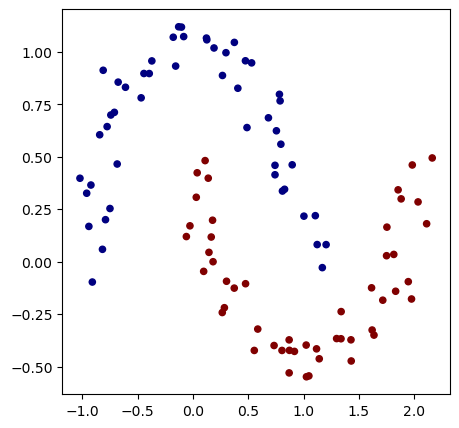

In [40]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import make_moons, make_blobs


np.random.seed(1337)
random.seed(1337)

# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 - 1  # make y be -1 or 1

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [41]:
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Model definition in PyTorch using nn.Sequential
## Create a PyTorch NN with two layers and 16 neurons in each layer
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)


In [42]:
# loss function
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = torch.tensor(Xb, dtype=torch.float32)
    labels = torch.tensor(yb, dtype=torch.float32).view(-1, 1)

    # forward the model to get scores
    scores = model(inputs)

    # svm "max-margin" loss
    losses = F.relu(1 + -labels*scores)
    data_loss = losses.mean()

    # Loss
    ### Implement L1 and L2 regularization here
    l1_lambda = 1e-4
    l2_lambda = 1e-4

    l1_penalty = sum(p.abs().sum() for p in model.parameters())
    l2_penalty = sum((p**2).sum() for p in model.parameters())

    total_loss = data_loss + l1_lambda*l1_penalty + l2_lambda*l2_penalty

    # also get accuracy
    accuracy = ((labels > 0) == (scores > 0)).float().mean()
    return total_loss, accuracy

total_loss, acc = loss()
print(total_loss.item(), acc.item())

# optimization
for k in range(100):
    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 10**(-k / 100)
    with torch.no_grad():
        for p in model.parameters():
            p -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.item()}, accuracy {acc*100}%")



1.0163058042526245 0.5
step 0 loss 1.0163058042526245, accuracy 50.0%
step 10 loss 0.31541672348976135, accuracy 85.0%
step 20 loss 0.26645398139953613, accuracy 89.0%
step 30 loss 0.23738552629947662, accuracy 91.0%
step 40 loss 0.21754854917526245, accuracy 91.0%
step 50 loss 0.20016300678253174, accuracy 91.0%
step 60 loss 0.18720099329948425, accuracy 92.0%
step 70 loss 0.17785610258579254, accuracy 93.0%
step 80 loss 0.17029765248298645, accuracy 93.0%
step 90 loss 0.16434863209724426, accuracy 93.0%


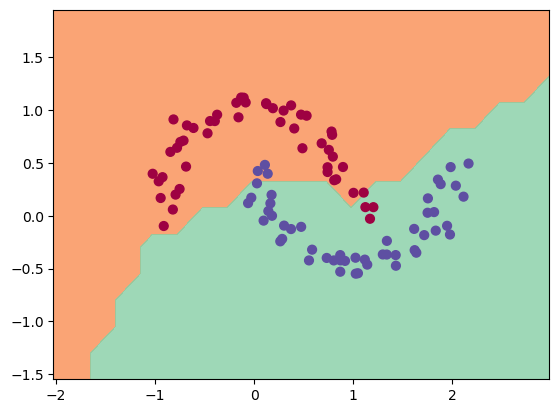

In [43]:

# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
with torch.no_grad():
    scores = model(torch.tensor(Xmesh, dtype=torch.float32))
Z = (scores > 0).numpy().reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

## Q1.2: 

I use a constant learning rate of 1.0. See the effect of LR by exponentially decaying LR with each iteration reaching a value of 0.1 at the end of the iterations.

# Q2: NN Example 3 - Herschel Bulkley model

Modify the hyperparameters such as number of layers, neurons, regularization, learning rate, etc and evaluate its effect

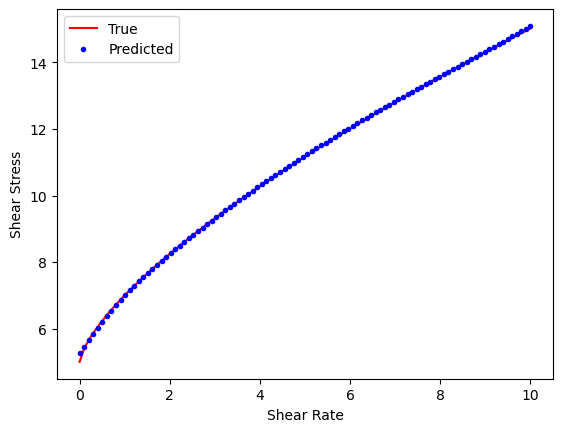

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate data
num_samples = 10000
v_values = torch.rand(num_samples, 1) * 10
tau0_values = torch.rand(num_samples, 1) * 5
k_values = torch.rand(num_samples, 1) * 2
n_values = torch.rand(num_samples, 1) * 0.5 + 0.5 # 0.5 - 1.0

# Inputs
inputs = torch.cat([v_values, tau0_values, k_values, n_values], dim=1)

# Targets
y_true = tau0_values + k_values * (v_values**n_values)

# Model
model = nn.Sequential(
   nn.Linear(4, 64),
   nn.Tanh(),
   nn.Linear(64,32),
   nn.Tanh(),
   nn.Linear(32,1)
)

# Training
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

epochs = 5000
for epoch in range(epochs):
   y_pred = model(inputs)
   loss = loss_fn(y_pred, y_true)

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

# Evaluation
v_eval = torch.linspace(0, 10, 100).unsqueeze(1)
tau0_eval = 5 * torch.ones_like(v_eval)
k_eval = 2 * torch.ones_like(v_eval)
n_eval = 0.7 * torch.ones_like(v_eval)

inputs_eval = torch.cat([v_eval, tau0_eval, k_eval, n_eval], dim=1)
y_pred = model(inputs_eval)

y_true_eval = tau0_eval + k_eval * (v_eval**n_eval)

# Plot
plt.plot(v_eval.numpy(), y_true_eval.numpy(), 'r-', label='True')
plt.plot(v_eval.numpy(), y_pred.detach().numpy(), 'b.', label='Predicted')
plt.xlabel('Shear Rate')
plt.ylabel('Shear Stress')
plt.legend()
plt.show()